In [ ]:
# prompt: connect to google drive to colab notebooks

from google.colab import drive
drive.mount('/content/drive')

In [5]:
%cd '/content/drive/MyDrive/CellDetection'

/content/drive/.shortcut-targets-by-id/1RmRatHewomojmWoyWqcqXkSj33dqkUR7/CellDetection


In [ ]:
!pip install ultralytics ND2Reader

Path for detection and pole classification models

In [7]:
DETECTION_MODEL_PATH = "celldetection.pt"
CLASSIFICATION_MODEL_PATH    = "classify_gamma10.pt"
# CLASSIFICATION_MODEL_PATH   = "classify_both7.pt"

# Pre-processing of ND2 image to PNG (using gamma and clahe)

    --------------------------------------------------------------
    Preprocess Image (ND2 / PNG / TIF)
    --------------------------------------------------------------
    INPUT:
        image_path    : Path to an ND2, PNG, TIFF, or JPG file.
        mode          : 'gamma', 'clahe', or 'both'
                        - gamma  → only gamma correction
                        - clahe  → only CLAHE contrast enhancement
                        - both   → gamma correction + CLAHE
        gamma         : Gamma value for gamma correction (default=10)
        clahe_clip    : CLAHE clip limit (default=2)
        clahe_tile    : CLAHE tile grid size (default=8×8)
        compare       : If True → displays original vs enhanced images
        save          : If True → saves enhanced PNG image
        output_path   : Optional path for saving.
                        If None → automatic naming:
                            - input.nd2 → input.png
                            - input.tif → input.png
                            - input.png → input_enhanced.png

    PROCESSING STEPS:
        1. Load ND2/PNG/TIF → uint16 image
        2. Apply selected enhancement (gamma / CLAHE / both)
        3. Normalize result to 0–255 → uint8
        4. Display comparison (if enabled)
        5. Save PNG output (if enabled)

    RETURNS:
        out (np.ndarray, uint8)
            The enhanced image in 8-bit format, suitable for YOLO
            or further processing.

    SIDE EFFECTS:
        - Displays a comparison figure (if compare=True)
        - Saves a PNG image (if save=True)



In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from nd2reader import ND2Reader
import imageio.v2 as imageio
import os

def load_image_any(path):
    ext = path.lower().split(".")[-1]

    if ext == "nd2":
        with ND2Reader(path) as nd2:
            iter_axes = ''.join([ax for ax in nd2.axes if ax not in ['x', 'y']])
            nd2.iter_axes = iter_axes if iter_axes else nd2.axes
            frame = nd2.get_frame(0)
        return np.asarray(frame).astype(np.uint16)

    return imageio.imread(path).astype(np.uint16)


def gamma_correction(image, gamma=10):
    img = image.astype(np.float32)
    img /= img.max()
    return np.power(img, 1/gamma)


def clahe_enhancement(image, clip=2.0, tile=(8,8)):
    if image.dtype == np.float32:
        img16 = (image * 65535).astype(np.uint16)
    else:
        img16 = image.astype(np.uint16)

    img8 = (img16 / 256).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    enhanced8 = clahe.apply(img8)

    return (enhanced8.astype(np.uint16) * 256)


def preprocess_image(
    image_path,
    mode="gamma",
    gamma=10,
    clahe_clip=8,
    clahe_tile=(8,8),
    compare=True,
    save=True,
    output_path=None
):
    """
    Matches old enhance_image() behavior:
    - mode: 'gamma', 'clahe', or 'both'
    - gamma default = 10
    - shows comparison
    - saves PNG with same base name
    """

    # Auto-generate output path
    if output_path is None:
        base = os.path.splitext(image_path)[0]
        output_path = base + ".png"

    # Load image
    img = load_image_any(image_path)

    # ---- Enhancement modes ----
    if mode == "gamma":
        enhanced = gamma_correction(img, gamma=gamma)

    elif mode == "clahe":
        enhanced = clahe_enhancement(img, clip=clahe_clip, tile=clahe_tile)

    elif mode == "both":
        g = gamma_correction(img, gamma=gamma)
        enhanced = clahe_enhancement(g, clip=clahe_clip, tile=clahe_tile)

    else:
        raise ValueError("mode must be 'gamma', 'clahe', or 'both'")

    # ---- Convert to uint8 ----
    out = enhanced.astype(np.float32)
    out -= out.min()
    out /= (out.max() if out.max() > 0 else 1)
    out = (out * 255).astype(np.uint8)

    # ---- Comparison display ----
    if compare:
        plt.figure(figsize=(18, 8))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap="gray")
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(out, cmap="gray")
        plt.title(f"Enhanced ({mode})")
        plt.axis("off")
        plt.show()

    # ---- Save ----
    if save:
        imageio.imwrite(output_path, out)
        print(f"✅ Saved enhanced → {output_path}")

    return out



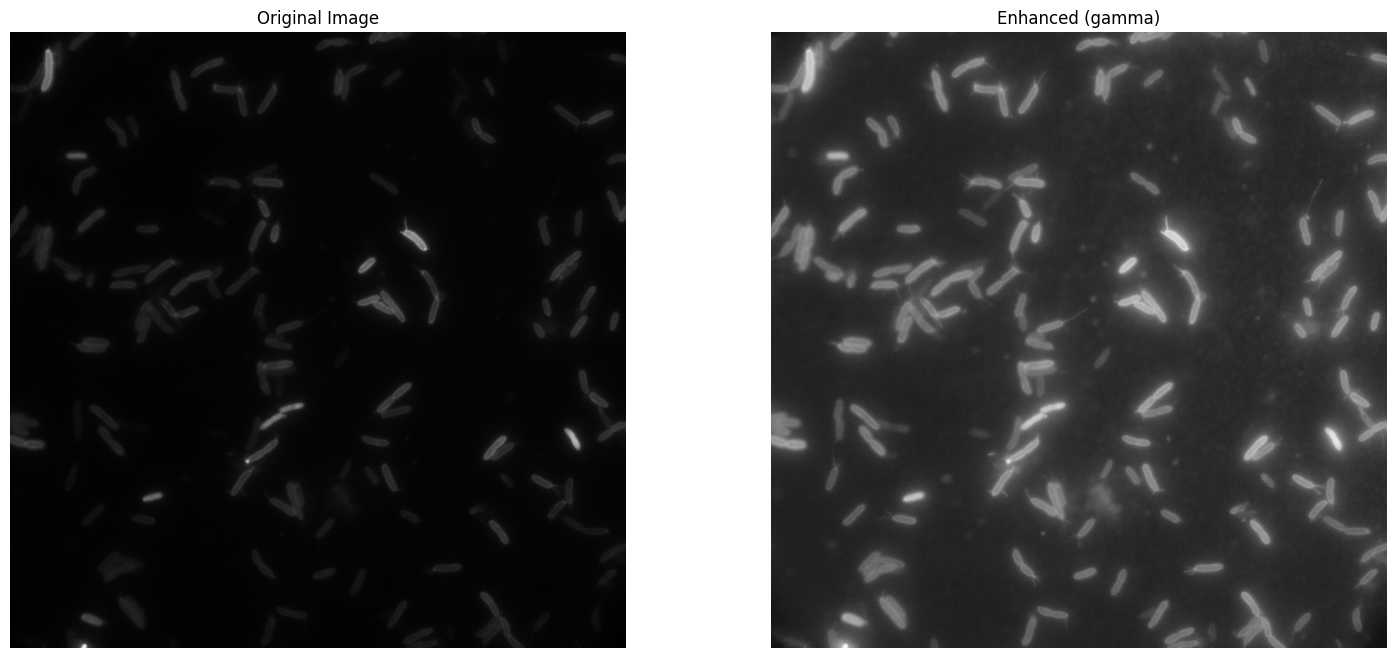

✅ Saved enhanced → 4hrs incu004.png
max: 255 min: 0


In [9]:
im = preprocess_image(
    image_path="4hrs incu004.nd2",
    mode="gamma",
    gamma=10,
    compare=True,
    save=True
)

print("max:", im.max(), "min:", im.min())


# Detection of Individual Cells

    --------------------------------------------------------------
    Detect Cells Using YOLO OBB (Oriented Bounding Boxes)
    --------------------------------------------------------------
    PURPOSE:
        Detect individual bacterial cells in a microscopy image using
        a YOLO OBB (oriented bounding box) model. This method supports
        rotated cell shapes and returns accurate cell geometry using
        cv2.minAreaRect.

    INPUT:
        image_to_detect      : Path to the enhanced microscopy image
                               (PNG/TIF/JPG). Must be loadable by OpenCV.

        detection_model_path : Path to trained YOLOv8 OBB model (.pt)
                               used for cell detection.

        block_size           : Size of sliding window (default: 640 px)
                               Larger block → fewer windows, faster.

        overlap              : Overlap amount between windows (default: 100 px)
                               Ensures no cells fall between tile boundaries.

        conf_threshold       : Minimum YOLO confidence score to accept detection.

        nms_threshold        : Rotated Non-Max Suppression threshold to
                               remove duplicate OBB detections.

        show                 : If True → display annotated image with detections.

    PROCESSING STEPS:
        1. Load enhanced image from disk.
        2. Slide a detection window of size block_size across the image
           with a stride of (block_size - overlap).
        3. Run YOLO OBB model on each window.
        4. For each detected OBB:
               • Extract corner points
               • Convert block-local coordinates → global coordinates
               • Convert corner points → cv2.minAreaRect() representation
        5. Aggregate all detections across all windows.
        6. Apply cv2.dnn.NMSBoxesRotated for rotated Non-Max Suppression.
           This removes overlapping duplicate detections.
        7. Draw final oriented bounding boxes on a copy of the image.
        8. Optionally display the annotated result (blue boxes).

    OUTPUT:
        detected_image : BGR image with blue oriented bounding boxes drawn
                         around all detected cells.

        rects : List of rotated rectangles.
                Each rect = ((cx, cy), (w, h), angle)
                where:
                    (cx, cy) = center of cell
                    (w, h)   = cell dimensions
                    angle    = cell rotation angle in degrees

    NOTES:
        - cv2.minAreaRect is used to capture orientation of elongated cells.
        - Sliding window ensures large images are handled without VRAM overflow.
        - The model supports fully rotated bacterial cells (not axis-aligned).
        - If no cells detected → returns original image and empty list.

    SIDE EFFECTS:
        - Optional display of detection result via matplotlib.
        - Terminal prints warnings for no detections or NMS filtering.


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os

def detect_cells(
    image_to_detect,
    detection_model_path,
    block_size=640,
    overlap=100,
    conf_threshold=0.7,
    nms_threshold=0.4,
    show=True
):
    """
    Detect cells in the given microscopy image (PNG/TIF/etc.) using YOLO OBB.

    Parameters:
        image_to_detect      : path to the enhanced image for detection
        detection_model_path : YOLO OBB model (.pt)
        block_size           : sliding window size (default 640)
        overlap              : overlap between windows (default 100)
        conf_threshold       : YOLO confidence threshold
        nms_threshold        : rotated NMS threshold
        show                 : display detection image

    Returns:
        detected_image : image with blue detection boxes drawn
        rects          : list of cv2.minAreaRect tuples (center, size, angle)
    """

    detection_model = YOLO(detection_model_path)

    # Load image
    img = cv2.imread(image_to_detect)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {image_to_detect}")

    img_disp = img.copy()
    img_h, img_w, _ = img.shape

    step = block_size - overlap
    all_rects, all_scores = [], []

    # Slide window across the image
    for y in range(0, img_h, step):
        for x in range(0, img_w, step):
            block = img[y:min(y + block_size, img_h), x:min(x + block_size, img_w)]
            results = detection_model.predict(block, conf=conf_threshold, verbose=False)

            if results and hasattr(results[0], "obb") and results[0].obb is not None:
                for box in results[0].obb:
                    corner_points = box.xyxyxyxy[0].cpu().numpy()

                    # convert back to global coordinates
                    corner_points[:, 0] += x
                    corner_points[:, 1] += y

                    rect = cv2.minAreaRect(corner_points.astype(np.float32))
                    all_rects.append(rect)
                    all_scores.append(float(box.conf.item()))

    if not all_rects:
        print("⚠️ No cells detected.")
        return img, []

    # Rotated NMS
    indices = cv2.dnn.NMSBoxesRotated(
        all_rects,
        all_scores,
        score_threshold=conf_threshold,
        nms_threshold=nms_threshold
    )

    if len(indices) == 0:
        print("⚠️ NMS removed all boxes.")
        return img, []

    indices = [i[0] if isinstance(i, (np.ndarray, list, tuple)) else i for i in indices]
    unique_cells_rects = [all_rects[i] for i in indices]

    # Draw detection boxes
    for rect in unique_cells_rects:
        box_pts = cv2.boxPoints(rect)
        cv2.drawContours(img_disp, [np.intp(box_pts)], -1, (255, 0, 0), 2)

    # Display
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
        plt.title("Detected Cells (no classification)")
        plt.axis("off")
        plt.show()

    return img_disp, unique_cells_rects


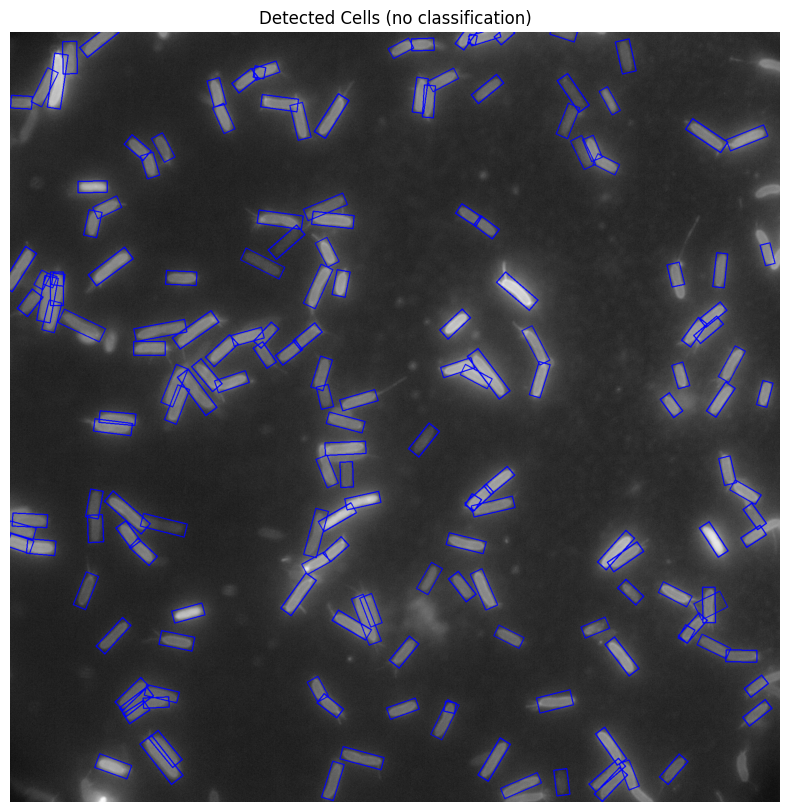

Detected 178 cells.


In [ ]:

IMAGE_TO_DETECT = "4hrs incu004.png"

det_img, rects = detect_cells(
    IMAGE_TO_DETECT,
    DETECTION_MODEL_PATH,
    show=True
)

print(f"Detected {len(rects)} cells.")


# Classification of cells based on poles type classification

    --------------------------------------------------------------
    Classify a Single Cell’s Poles Using YOLO Pole Classifier
    --------------------------------------------------------------
    INPUT:
        full_image_bgr   : Full microscopy image in BGR format
        rect             : Rotated rectangle returned by cv2.minAreaRect:
                               rect = ((cx, cy), (w, h), angle)
                           Represents location and orientation of the cell.

        classification_model : Loaded YOLO classifier object
                               (already constructed with YOLO(weights_path))

        extension_factor : Amount of padding added above & below the cell
                           to ensure both poles are captured (default 0.20)

    WHAT THIS FUNCTION DOES:
        1. Takes a rotated bounding box representing the detected cell.
        2. Normalizes orientation:
               - Ensures long axis becomes vertical
               - Rotates the *entire image* around cell center
        3. Extracts a tall, upright crop around the cell, including poles.
        4. Splits this crop into two halves:
               • Top half    → Pole 1
               • Bottom half → Pole 2
        5. Runs YOLO pole classifier on each pole independently.
        6. Determines:
               - free_poles      → how many poles are "free" (class 0)
               - predicted_class → converted to cell-level label:
                                      2 free → class 0
                                      1 free → class 1
                                      0 free → class 2
        7. Determines a visualization color based on free pole count:
               • 2 free → Green
               • 1 free → Yellow
               • 0 free → Red
        8. Returns all classification information in a clean dictionary.

    RETURNS (dictionary with the following keys):
        {
            "rect"            : original rotated cell rectangle
            "predicted_class" : integer cell class (0, 1, or 2)
            "free_poles"      : number of free poles (0, 1, or 2)
            "crop"            : upright rotated crop containing both poles
            "color"           : BGR color tuple used for annotation
        }

    SIDE EFFECTS:
        - None (this function does NOT draw or display anything)
        - Purely computational: safe for batch processing


    --------------------------------------------------------------
    Classify Poles for All Detected Cells in an Image
    --------------------------------------------------------------
    INPUT:
        image_path              : Path to processed microscopy image (PNG)
        rect_list               : List of cell rectangles from detect_cells()
                                  Each rect = ((cx,cy), (w,h), angle)

        classification_model_path : Path to YOLO pole-classification model
        show                      : If True → display final annotated image

    WHAT THIS FUNCTION DOES:
        1. Loads the input image.
        2. Loads the YOLO pole-classification model.
        3. Iterates over every detected cell rectangle.
        4. Calls classify_single_cell() on each:
               • Produces pole1 / pole2 predictions
               • Determines free poles
               • Maps to cell-level class
               • Returns rotated crop and annotation color
        5. Draws a rotated bounding box on the image using:
               • Green  → 2 free poles
               • Yellow → 1 free pole
               • Red    → 0 free poles
        6. Aggregates all per-cell predictions.

    OUTPUT:
        annotated_img : Image with color-coded rotated bounding boxes
        predictions   : List of dictionaries, one for each cell:
                        {
                            "rect": ...,
                            "predicted_class": ...,
                            "free_poles": ...,
                            "crop": ...,
                            "color": ...
                        }

    SIDE EFFECTS:
        - If show=True, displays a figure showing all classified cells
        - No saving is performed automatically


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np

def classify_single_cell(
    full_image_bgr,
    rect,
    classification_model,
    extension_factor=0.20
):
    """
    Classify a single detected cell using your pole-split logic.
    """
    img_h, img_w, _ = full_image_bgr.shape

    center, size, angle = rect
    width, height = size

    # Normalize so long axis is vertical
    if width > height:
        width, height = height, width
        angle += 90

    extension = extension_factor * height

    # Rotate whole image so the cell's long axis is vertical
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_img = cv2.warpAffine(full_image_bgr, M, (img_w, img_h))

    # Crop extended region to capture both poles
    crop_size = (int(width), int(height + 2 * extension))
    super_crop = cv2.getRectSubPix(rotated_img, crop_size, center)

    if super_crop is None or super_crop.size == 0:
        return None

    # Split poles
    mid_point_y = int(extension + height / 2)
    pole1 = super_crop[0:mid_point_y, :]
    pole2 = super_crop[mid_point_y:, :]

    # Run classifier on both poles
    results = classification_model.predict([pole1, pole2], verbose=False)

    # Count "free poles" (YOLO class 0)
    free_poles = sum(1 for r in results if r.probs.top1 == 0)

    # Map free_poles to cell class
    pred_class_map = {2: 0, 1: 1, 0: 2}
    predicted_class = pred_class_map[free_poles]

    # Color map for display
    color_map = {2: (0, 255, 0), 1: (0, 255, 255), 0: (0, 0, 255)}
    color = color_map.get(free_poles, (255, 255, 255))

    return {
        "rect": rect,
        "predicted_class": predicted_class,
        "free_poles": free_poles,
        "crop": super_crop,
        "color": color
    }


def classify_all_cells(
    image_path,
    rect_list,
    classification_model_path,
    show=True
):
    """
    Run pole classification for ALL detected cells.

    Inputs:
        image_path: path to the processed PNG
        rect_list: list of cv2.minAreaRect rects (output of detect_cells)
        classification_model_path: YOLO classifier path

    Returns:
        annotated_img: image with colored contours
        predictions: list of dictionaries (one per cell)
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {image_path}")

    img_display = img.copy()
    classification_model = YOLO(classification_model_path)

    predictions = []

    for rect in rect_list:
        result = classify_single_cell(img, rect, classification_model)
        if result is None:
            continue

        predictions.append(result)

        # Draw classification-colored rotated box
        box = cv2.boxPoints(rect)
        box = np.intp(box)
        cv2.drawContours(img_display, [box], 0, result["color"], 2)

    # Display final annotated image
    if show:
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
        plt.title("All Cell Classifications")
        plt.axis("off")
        plt.show()

    return img_display, predictions


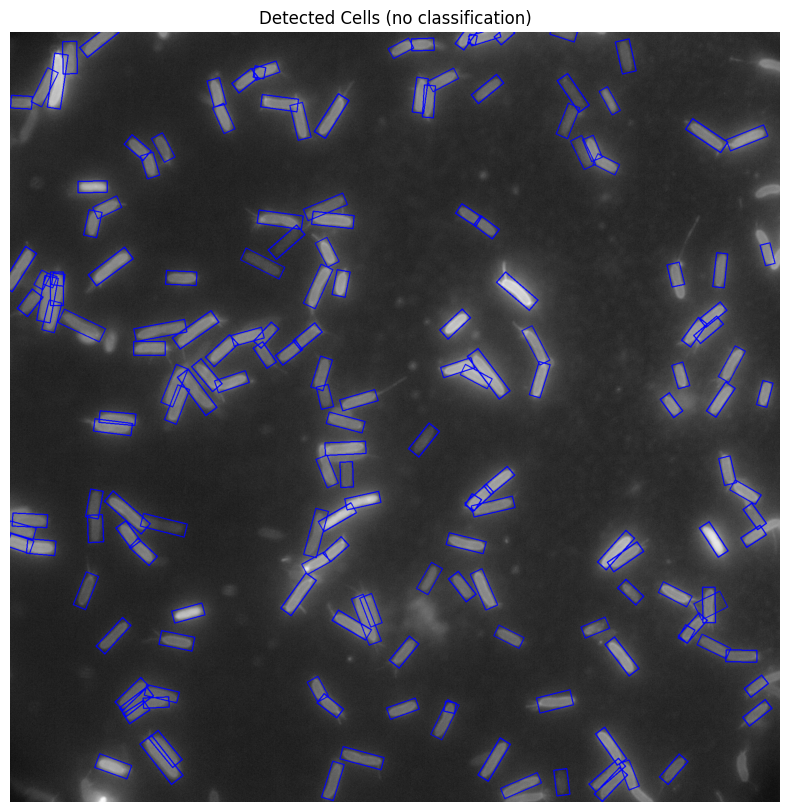

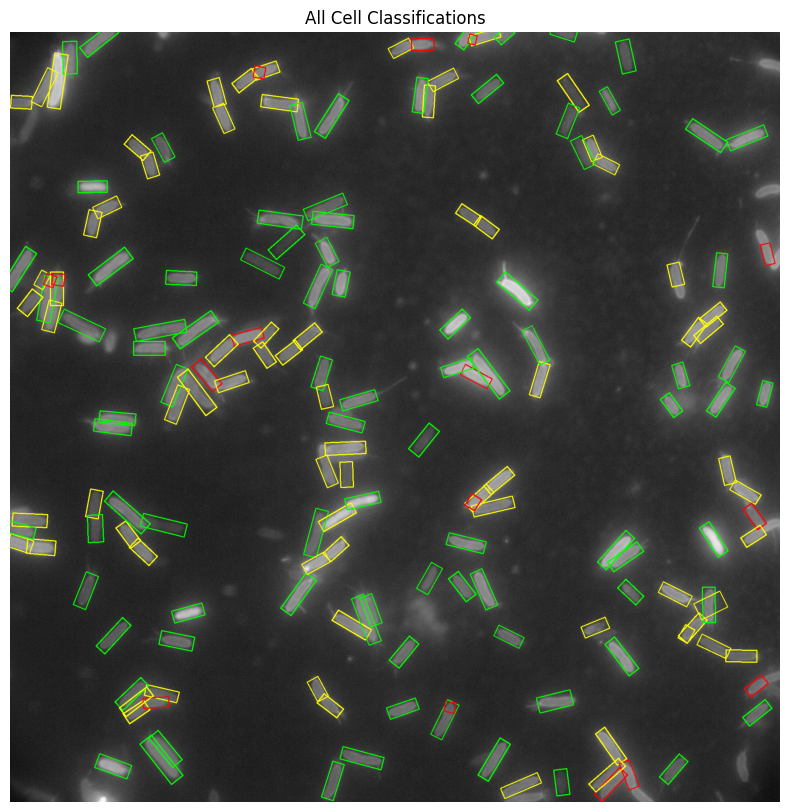

Total cells classified: 178


In [ ]:
IMAGE = "4hrs incu004.png"

# Step 1: Detect all cells
det_img, rects = detect_cells(
    IMAGE,
    DETECTION_MODEL_PATH,
    block_size=640,
    overlap=100,
    conf_threshold=0.7
)

# Step 2: Classify all detected cells
classified_img, predictions = classify_all_cells(
    IMAGE,
    rects,
    CLASSIFICATION_MODEL_PATH
)

print(f"Total cells classified: {len(predictions)}")


# Comparison with ground truth

1. calculate_iou_rotated()
   Computes IoU between two rotated rectangles using OpenCV’s
   rotatedRectangleIntersection. Measures overlap accuracy for angled cells.

2. evaluate_performance()
   Compares predicted cells vs. ground truth:
       - matches predictions using IoU
       - counts correct classifications
       - reports false negatives & false positives
   Prints accuracy summary.

3. draw_ground_truth()
   Loads image + YOLO polygon labels, converts polygons into rotated
   rectangles (cv2.minAreaRect), draws GT boxes (classes 0,1,2), and returns
   GT rectangles and class labels.

4. get_predicted_image()
   Full detection + classification pipeline:
       - Runs YOLO OBB cell detection with sliding-window
       - Applies rotated NMS to remove duplicates
       - For each detected cell:
             rotate → crop → split poles → classify
       - Maps free-pole count to final cell class (0,1,2)
       - Draws colored rotated bounding boxes
   Returns annotated prediction image + predicted rects and classes.


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os

# ================================================================
# 1. ROTATED IoU
# ================================================================
def calculate_iou_rotated(rect1, rect2):
    inter_type, contour = cv2.rotatedRectangleIntersection(rect1, rect2)
    if contour is None:
        return 0.0
    inter_area = cv2.contourArea(contour)
    area1 = rect1[1][0] * rect1[1][1]
    area2 = rect2[1][0] * rect2[1][1]
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0.0


# ================================================================
# 2. PERFORMANCE EVALUATION
# ================================================================
def evaluate_performance(gt_data, pred_data, iou_threshold=0.5):
    gt_rects, gt_classes = gt_data
    pred_rects, pred_classes = pred_data

    total_gt = len(gt_rects)
    total_pred = len(pred_rects)

    if total_gt == 0:
        print("No ground truth boxes to evaluate.")
        return

    correct = 0
    matched_gt = set()

    for i, pred_rect in enumerate(pred_rects):
        best_iou = 0
        best_idx = -1

        for j, gt_rect in enumerate(gt_rects):
            iou = calculate_iou_rotated(pred_rect, gt_rect)
            if iou > best_iou:
                best_iou = iou
                best_idx = j

        if best_iou > iou_threshold and best_idx not in matched_gt:
            matched_gt.add(best_idx)
            if pred_classes[i] == gt_classes[best_idx]:
                correct += 1

    missed = total_gt - len(matched_gt)
    fp = total_pred - len(matched_gt)
    accuracy = (correct / total_gt * 100) if total_gt else 0

    print("\n--- Performance Evaluation Report ---")
    print(f"Ground Truth Cells  : {total_gt}")
    print(f"Predicted Cells     : {total_pred}")
    print("-------------------------------------")
    print(f"Correct Predictions : {correct}")
    print(f"Missed (FN)         : {missed}")
    print(f"False Positives (FP): {fp}")
    print(f"\nAccuracy: {accuracy:.2f}%")
    print("-------------------------------------")


# ================================================================
# 3. LOAD AND DRAW GROUND TRUTH
# ================================================================
def draw_ground_truth(image_path, label_path):
    img = cv2.imread(image_path)
    img_h, img_w, _ = img.shape

    gt_rects, gt_classes = [], []
    gt_color_map = {0:(0,255,0), 1:(0,255,255), 2:(0,0,255)}

    if not os.path.exists(label_path):
        print("❌ Label file missing:", label_path)
        return None, ([], [])

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.split()
        cls = int(parts[0])

        # Skip irrelevant classes
        if cls not in gt_color_map:
            continue

        coords = np.array([float(p) for p in parts[1:]]).reshape(-1, 2)
        coords = (coords * np.array([img_w, img_h])).astype(np.float32)

        rect = cv2.minAreaRect(coords)
        gt_rects.append(rect)
        gt_classes.append(cls)

        pts = coords.reshape(-1,1,2).astype(np.int32)
        cv2.polylines(img, [pts], True, gt_color_map[cls], 2)

    return img, (gt_rects, gt_classes)


# ================================================================
# 4. FULL PREDICTION (DETECTION + CLASSIFICATION)
# ================================================================
def get_predicted_image(
    detection_model_path,
    classification_model_path,
    image_path,
    block_size=640,
    overlap=100,
    conf_threshold=0.7
):
    det_model = YOLO(detection_model_path)
    clf_model = YOLO(classification_model_path)

    img = cv2.imread(image_path)
    img_disp = img.copy()
    img_h, img_w = img.shape[:2]

    all_rects, all_scores = [], []
    step = block_size - overlap

    # ---- Cell Detection (Sliding Window)
    for y in range(0, img_h, step):
        for x in range(0, img_w, step):
            block = img[y:min(y+block_size,img_h), x:min(x+block_size,img_w)]
            results = det_model.predict(block, conf=conf_threshold, verbose=False)

            if results and results[0].obb is not None:
                for b in results[0].obb:
                    pts = b.xyxyxyxy[0].cpu().numpy()
                    pts[:,0] += x
                    pts[:,1] += y
                    rect = cv2.minAreaRect(pts.astype(np.float32))
                    all_rects.append(rect)
                    all_scores.append(float(b.conf.item()))

    if len(all_rects) == 0:
        return img, ([], [])

    # ---- Robust Rotated NMS
    indices = cv2.dnn.NMSBoxesRotated(all_rects, all_scores, conf_threshold, 0.4)

    clean_inds = []
    for idx in indices:
        if isinstance(idx, (list,tuple,np.ndarray)):
            clean_inds.append(int(idx[0]))
        else:
            clean_inds.append(int(idx))

    unique_rects = [all_rects[i] for i in clean_inds]

    pred_rects, pred_classes = [], []
    pred_color_map = {2:(0,255,0), 1:(0,255,255), 0:(0,0,255)}

    # ---- Classification of Each Detected Cell
    for rect in unique_rects:
        center, size, angle = rect
        w, h = size

        if w > h:
            w, h = h, w
            angle += 90

        extension = 0.20 * h
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(img, M, (img_w, img_h))

        crop_size = (int(w), int(h + 2 * extension))
        crop = cv2.getRectSubPix(rotated, crop_size, center)

        if crop is None or crop.size == 0:
            continue

        mid = int(extension + h/2)
        pole1 = crop[:mid]
        pole2 = crop[mid:]

        results = clf_model.predict([pole1, pole2], verbose=False)
        free_poles = sum(1 for r in results if r.probs.top1 == 0)

        pred_class_map = {2:0, 1:1, 0:2}
        predicted_class = pred_class_map[free_poles]

        pred_rects.append(rect)
        pred_classes.append(predicted_class)

        color = pred_color_map[free_poles]
        pts = cv2.boxPoints(rect)
        cv2.drawContours(img_disp, [np.intp(pts)], -1, color, 2)

    return img_disp, (pred_rects, pred_classes)





Generating Ground Truth visualization...

Generating Model Prediction visualization...

Evaluating performance...

--- Performance Evaluation Report ---
Ground Truth Cells  : 140
Predicted Cells     : 178
-------------------------------------
Correct Predictions : 111
Missed (FN)         : 11
False Positives (FP): 49

Accuracy: 79.29%
-------------------------------------


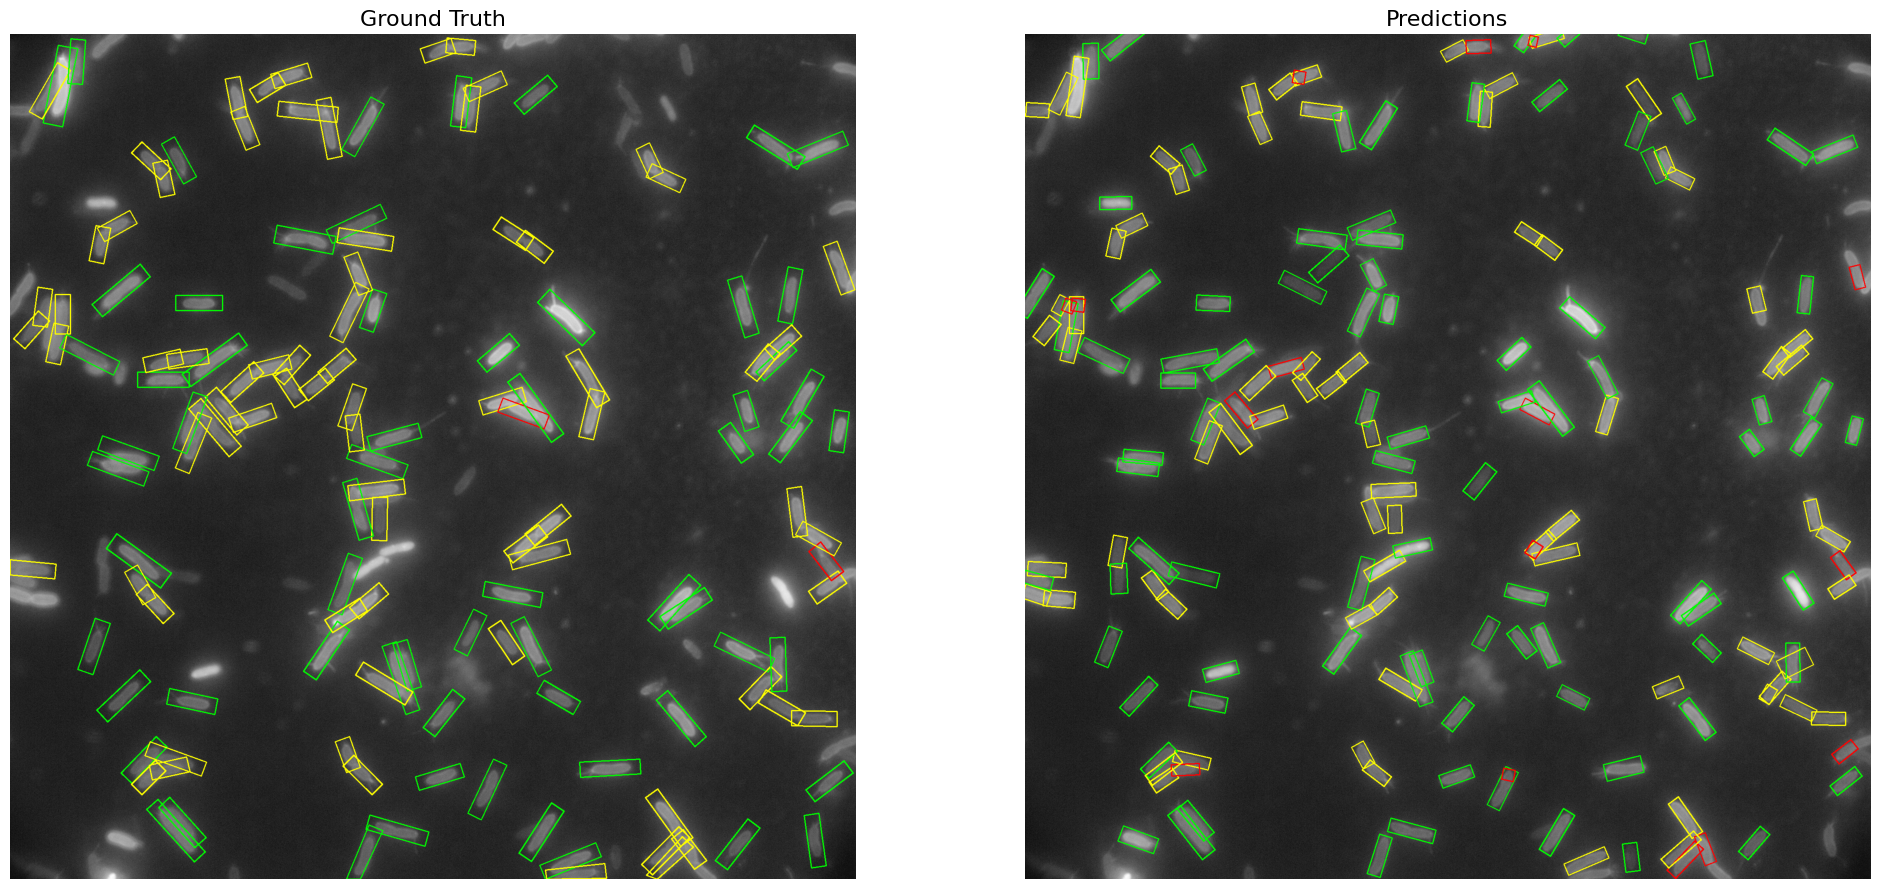

In [ ]:
# ================================================================
# 5. MAIN EXECUTION BLOCK
# ================================================================
if __name__ == "__main__":

    IMAGE_TO_COMPARE = "/content/drive/MyDrive/CellDetection/4hrs incu004.png"
    GROUND_TRUTH_LABEL = "/content/drive/MyDrive/CellDetection/4hrs incu004.txt"

    print("Generating Ground Truth visualization...")
    gt_image, gt_data = draw_ground_truth(IMAGE_TO_COMPARE, GROUND_TRUTH_LABEL)

    print("\nGenerating Model Prediction visualization...")
    pred_image, pred_data = get_predicted_image(
        DETECTION_MODEL_PATH,
        CLASSIFICATION_MODEL_PATH,
        IMAGE_TO_COMPARE
    )

    print("\nEvaluating performance...")
    evaluate_performance(gt_data, pred_data)

    # ---- SHOW SIDE-BY-SIDE ----
    if gt_image is not None and pred_image is not None:
        fig, axes = plt.subplots(1, 2, figsize=(24, 12))
        axes[0].imshow(cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Ground Truth", fontsize=16)
        axes[0].axis("off")

        axes[1].imshow(cv2.cvtColor(pred_image, cv2.COLOR_BGR2RGB))
        axes[1].set_title("Predictions", fontsize=16)
        axes[1].axis("off")

        plt.show()

# Full Pipeline

In [ ]:
def run_full_pipeline(
    input_path,
    detection_model_path,
    classification_model_path,
    preprocess_mode="gamma",
    gamma=10,
    clahe_clip=8,
    clahe_tile=(8,8),
    block_size=640,
    overlap=100,
    conf_threshold=0.7,
    show_steps=True
):
    """
    Complete pipeline:
        ND2 → Preprocess → Detect Cells → Classify Poles → Annotate Output

    INPUT:
        input_path              : ND2 or PNG/TIF image path
        detection_model_path    : YOLO OBB model (.pt)
        classification_model_path : YOLO pole classifier (.pt)
        preprocess_mode         : 'gamma', 'clahe', or 'both'
        show_steps              : If True, displays intermediate results

    OUTPUT:
        {
            "preprocessed_image_path": <path>,
            "detection_rects": list of detected cv2.minAreaRect rects,
            "predictions": list of classification dicts,
            "annotated_image": final result image
        }
    """

    # ----------------------------------------------------
    # Step 1 — Preprocessing (ND2 → Enhanced PNG)
    # ----------------------------------------------------
    print("📌 Step 1: Preprocessing input image...")

    preprocessed_img = preprocess_image(
        image_path=input_path,
        mode=preprocess_mode,
        gamma=gamma,
        clahe_clip=clahe_clip,
        clahe_tile=clahe_tile,
        compare=show_steps,
        save=True
    )

    # Determine saved PNG path
    preprocessed_path = os.path.splitext(input_path)[0] + ".png"

    # ----------------------------------------------------
    # Step 2 — Cell Detection
    # ----------------------------------------------------
    print("🔎 Step 2: Detecting cells...")

    det_img, rects = detect_cells(
        image_to_detect=preprocessed_path,
        detection_model_path=detection_model_path,
        block_size=block_size,
        overlap=overlap,
        conf_threshold=conf_threshold,
        show=show_steps
    )

    if len(rects) == 0:
        print("⚠️ No detected cells. Pipeline stopped.")
        return {
            "preprocessed_image_path": preprocessed_path,
            "detection_rects": [],
            "predictions": [],
            "annotated_image": det_img
        }

    # ----------------------------------------------------
    # Step 3 — Pole Classification
    # ----------------------------------------------------
    print("🧪 Step 3: Classifying poles for each detected cell...")

    annotated_img, predictions = classify_all_cells(
        image_path=preprocessed_path,
        rect_list=rects,
        classification_model_path=classification_model_path,
        show=show_steps
    )

    # ----------------------------------------------------
    # Return complete output
    # ----------------------------------------------------
    return {
        "preprocessed_image_path": preprocessed_path,
        "detection_rects": rects,
        "predictions": predictions,
        "annotated_image": annotated_img
    }


📌 Step 1: Preprocessing input image...


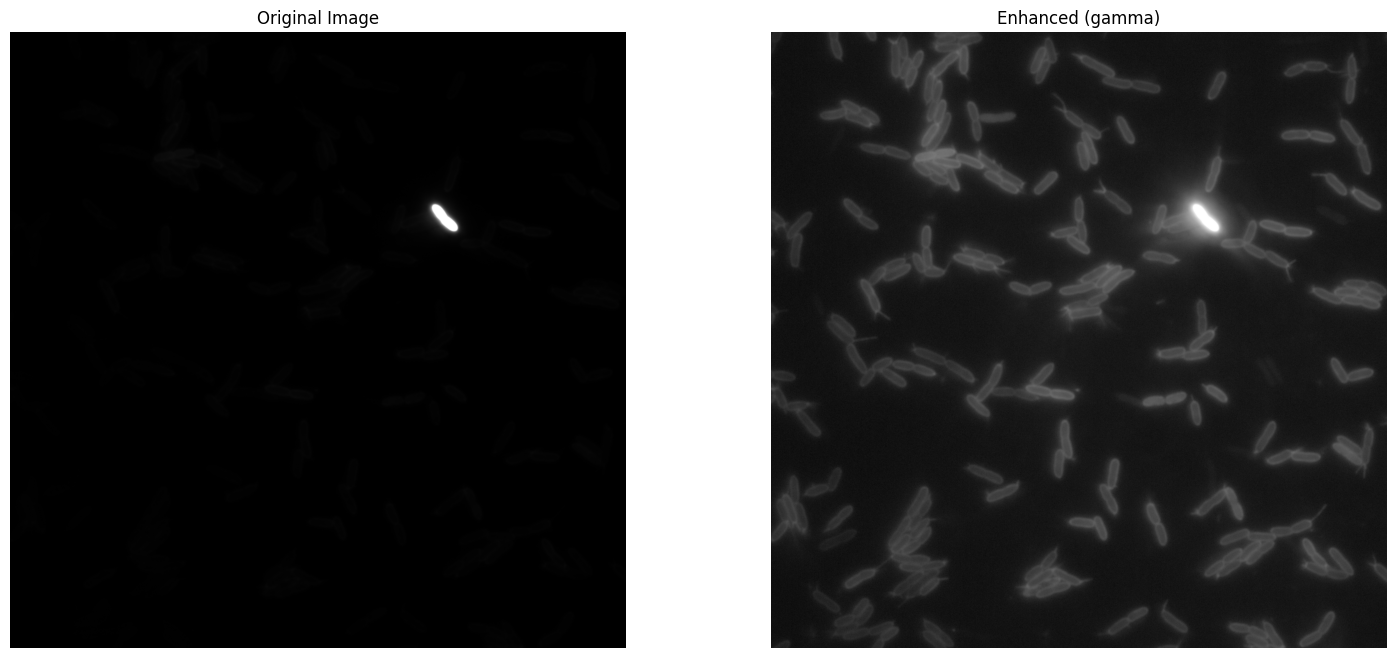

✅ Saved enhanced → 20mins021.png
🔎 Step 2: Detecting cells...


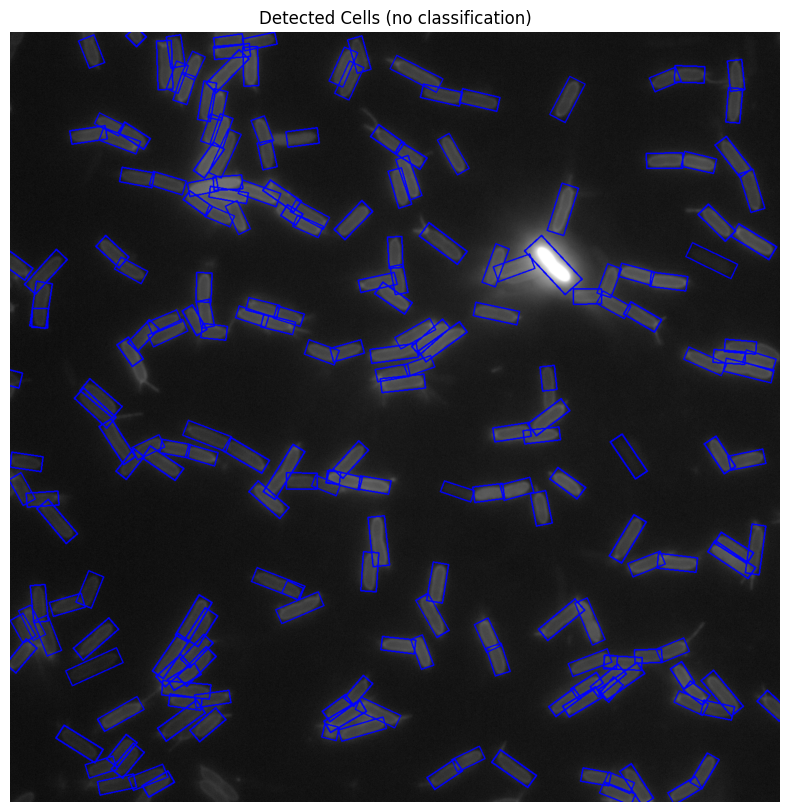

🧪 Step 3: Classifying poles for each detected cell...


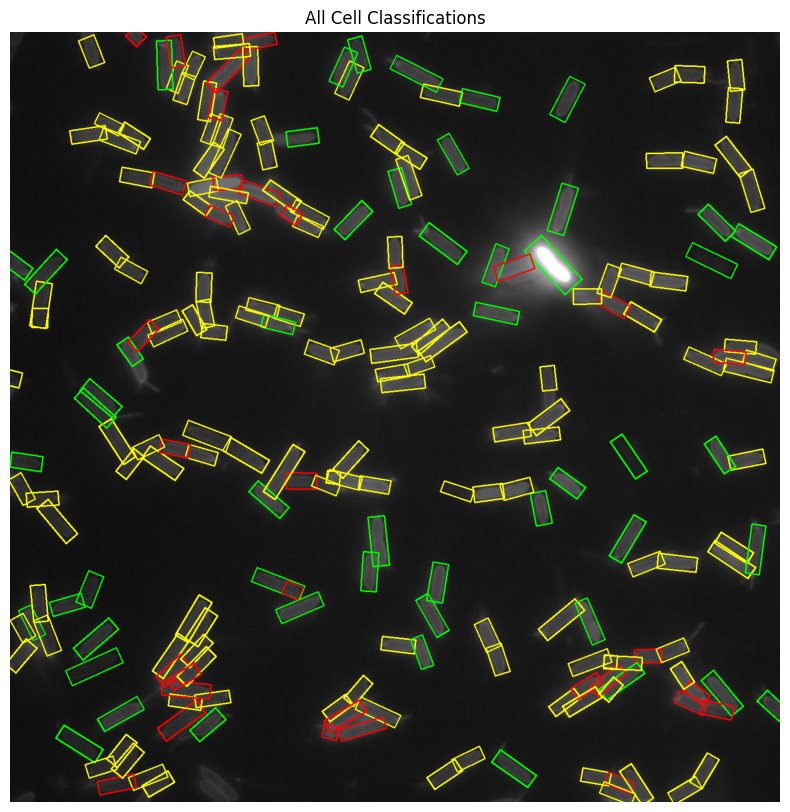

In [ ]:
result = run_full_pipeline(
    input_path="20mins021.nd2",
    detection_model_path=DETECTION_MODEL_PATH,
    classification_model_path= CLASSIFICATION_MODEL_PATH ,
    preprocess_mode="gamma",   # "gamma" / "clahe" / "both"
    gamma = 10,
    show_steps=True
)

# Access results:
annotated = result["annotated_image"]
preds = result["predictions"]
rects = result["detection_rects"]
